In [1]:
# creat all figures
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import matplotlib.patches as mpatches
from matplotlib import rc
# import latex
rc("text", usetex=False)

Plot RMSE from cross validation

In [2]:
%load_ext autoreload
%autoreload 2
from basic.plot import plot_error_cv

plt.rcParams["text.usetex"] = False
sns.set_style('darkgrid')

In [3]:
def df_return(fp, fn):
    error_stats = pd.read_csv(f'{fp}{fn}', index_col = 'index')
    cols = error_stats.columns
    error_stats.loc[:, cols[1]] = error_stats.loc[:, cols[0]] - error_stats.loc[:, cols[1]]
    error_stats.loc[:, cols[2]] = error_stats.loc[:, cols[2]] - error_stats.loc[:, cols[0]]  
    df_temp = error_stats.iloc[:]
    
    return df_temp

In [11]:
# Plot errors of cross-validation
from matplotlib import rcParams

filepath = ['../output/paper0915/', '../output/paper0915/figure4/test_plot/', '../output/paper0915/figure4/test1013/']
filename = ['error_cv_uniform_552.csv', 'error_cv_beta_552.csv']
filename_22 = 'error_cv_compare.csv'

error_stats = pd.read_csv(f'{filepath[0]}{filename_22}').iloc[0]

df_uniform = df_return(filepath[1], filename[0])
cols = df_uniform.columns
df_uniform.rename(columns={col: col+'_uni' for col in cols}, inplace=True)
df_beta = df_return(filepath[1], filename[1])
df_beta.rename(columns={col: col+'_beta' for col in cols}, inplace=True)
df = pd.concat([df_uniform, df_beta], axis=1)
df.loc['nsample_552', 'mean_22_uni'] = error_stats['mean']
# df.loc['nsample_552', 'mean_22_uni'] = error_stats['mean']
df.loc['nsample_552', 'lower_22_uni'] = error_stats['mean'] - error_stats['lower']
df.loc['nsample_552', 'upper_22_uni'] = error_stats['upper'] - error_stats['mean']

# error_stats = pd.read_csv(f'{filepath[1]}{filename_22}').iloc[0]

df_uniform = df_return(filepath[2], filename[0])
df_uniform.rename(columns={col: col+'_uni' for col in cols}, inplace=True)
df_beta = df_return(filepath[2], filename[1])
df_beta.rename(columns={col: col+'_beta' for col in cols}, inplace=True)
df_allsamples = pd.concat([df_uniform, df_beta], axis=1)
df_allsamples.loc['nsample_552', 'mean_22_uni'] = error_stats['mean']
# df.loc['nsample_552', 'mean_22_uni'] = error_stats['mean']
df_allsamples.loc['nsample_552', 'lower_22_uni'] = error_stats['mean'] - error_stats['lower']
df_allsamples.loc['nsample_552', 'upper_22_uni'] = error_stats['upper'] - error_stats['mean']

df_cols = df.columns
keys = ['legend', 'legend_low', 'legend_up']
legend_dict = {}
for ind in range(len(keys)):
    legend_dict[keys[ind]] = [df_cols[i] for i in range(len(df_cols)) if (i % 3) ==ind]

df = df.reset_index()
df_allsamples = df_allsamples.reset_index()
# plt.savefig(f'{filepath}/figure/pce_compare.png', format='png', dpi=300)

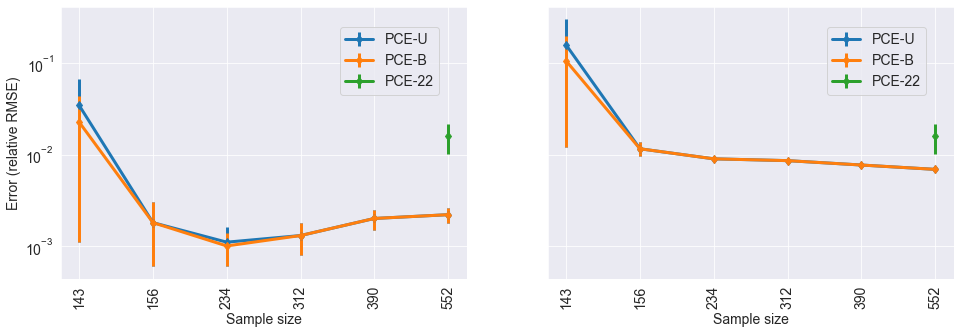

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 5))
ax1 = df.plot(x='index', y=legend_dict['legend'], kind='line', marker='d',
                yerr=df.loc[:, [*legend_dict['legend_low'], *legend_dict['legend_up']]].T.values, 
                legend=True, logy=True, xticks=np.arange(df.shape[0]), ax=axes[0])

ax1.set_xticklabels(labels = [143, 156, 234, 312, 390, 552], fontsize = 14, rotation=90);
rcParams['ytick.labelsize'] = 14
ax1.legend(['PCE-U', 'PCE-B', 'PCE-22'], bbox_to_anchor=(0.95, 0.95), fontsize=14)
ax1.set_ylabel('Error (relative RMSE)', fontsize = 14);
ax1.set_xlabel('Sample size', fontsize = 14);

ax2 = df_allsamples.plot(x='index', y=legend_dict['legend'], kind='line', marker='d',
                yerr=df_allsamples.loc[:, [*legend_dict['legend_low'], *legend_dict['legend_up']]].T.values, 
                legend=True, logy=True, xticks=np.arange(df_allsamples.shape[0]), ax=axes[1])

ax2.set_xticklabels(labels = [143, 156, 234, 312, 390, 552], fontsize = 14, rotation=90);
rcParams['ytick.labelsize'] = 14
ax2.legend(['PCE-U', 'PCE-B', 'PCE-22'], bbox_to_anchor=(0.95, 0.95), fontsize=14)
ax2.set_ylabel('Error (relative RMSE)', fontsize = 14);
ax2.set_xlabel('Sample size', fontsize = 14);
plt.savefig(f'{filepath[0]}/figure/Figure4_two_panels.png', format='png', dpi=300)

## Bar plot of sensitivity indices

In [29]:
# sensitivity plot
filepath = '../output/paper/'
df_plot = pd.read_csv(f'{filepath}sa_fig2.csv', index_col= 'Unnamed: 0')

sns.set_style('white')
current_palette = sns.color_palette()
# sns.set_color_codes(current_palette)
fig = plt.figure(figsize=(8, 6))
colors = list(np.where(df_plot.Type_num == 0, 0, 2))
colors = [current_palette[c] for c in colors]
ax = df_plot.plot(x='short_name', y='ST', kind='bar', 
                yerr='ST_conf', color=colors, legend=False, logy=False)
ax.set_ylabel('Total effects', fontsize=10)
ax.set_xlabel('Parameters', fontsize=10)
ax.tick_params(axis='x', which='major', labelsize=8)
index = [0, 20, 28]
xmin, ymin = [-0.3, 19.5, 27.5], 0
height, width = 0.79, [9.8, 3, 3]
for i  in range(len(index)):
    ax.add_patch(
        mpatches.Rectangle(
            xy=(xmin[i], ymin),  # point of origin.
            width=width[i],
            height=height,
            linewidth=1,
            color=current_palette[1],
            fill=False,
            linestyle='--'
        )
)   
SPL = mpatches.Patch(color=current_palette[0], label='Sampling')
PCE_Beta = mpatches.Patch(color=current_palette[2], label='PCE')
ax.legend(handles=[SPL, PCE_Beta], fontsize=8, loc=9) 
# plt.savefig(f'{filepath}figure/sentivity_fig1.png', format='png', dpi=300, bbox_inches='tight')

AttributeError: 'DataFrame' object has no attribute 'Type_num'

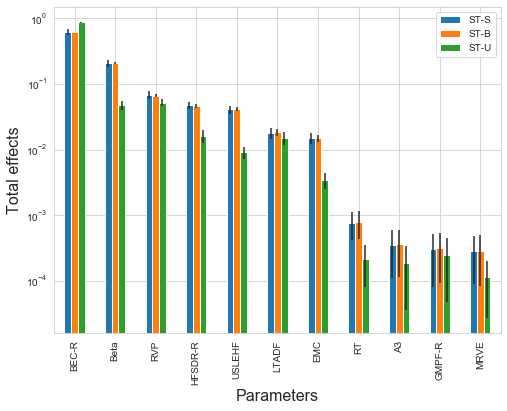

In [4]:
# plot sensitivity for PCE with 11 parameters of Beta, Uniform dists
filepath = '../output/paper0915/'
df_plot = pd.read_csv(f'{filepath}sa_fig2.csv', index_col= 'Unnamed: 0')
cols = df_plot.columns
legend = ['ST', 'ST_Beta', 'ST_Uniform']
legend_low = [lab+'_conf_lower' for lab in legend]
legend_up = [lab+'_conf_upper' for lab in legend]
for lab in legend:
    df_plot.loc[:, f'{lab}_conf_lower'] = df_plot.loc[:, lab] - df_plot.loc[:, f'{lab}_conf_lower'] 
    df_plot.loc[:, f'{lab}_conf_upper'] = df_plot.loc[:, f'{lab}_conf_upper'] - df_plot.loc[:, lab]

sns.set_style('whitegrid')
ax = df_plot.plot(x='short_name', y=legend, kind='bar', figsize=(8,6),
                yerr=df_plot.loc[:, [*legend_low, *legend_up]].T.values, 
                legend=True, logy=True, xticks=np.arange(df_plot.shape[0]))
ax.set_ylabel('Total effects', fontsize=16);
ax.set_xlabel('Parameters', fontsize=16); 
ax.set_xticklabels(df_plot.short_name.values, rotation=90);
ax.legend(['ST-S', 'ST-B', 'ST-U'])
plt.savefig(f'{filepath}figure/Figure5-log-bar.png', format='png', dpi=300, bbox_inches='tight') 

## Plot Figure 7

In [48]:
# calculate the changes in the confidence intervals
# heat map 
filepath = '../output/paper0915/error_measures/1029_cal/'
filename = ['cf_width', 'cf_width_lower', 'cf_width_upper']
df_mean = pd.read_csv(f'{filepath}{filename[0]}.csv', index_col = 'Unnamed: 0')
df_lower = pd.read_csv(f'{filepath}{filename[1]}.csv', index_col = 'Unnamed: 0')
df_upper = pd.read_csv(f'{filepath}{filename[2]}.csv', index_col = 'Unnamed: 0')
df_lower = 1 - df_lower
cols = df_mean.columns
for col in cols:
    ind = df_mean[df_mean[col]>1].index.tolist()
    if len(ind) > 0: df_lower.loc[ind, col] = 1 - df_upper.loc[ind, col]
# df_lower.to_csv(f'{filepath}cf_changes.csv', index=True)

Line plot for three error measures

In [49]:
# prepare the data for plot: confidence intervals and the coefficient of variation
filepath = '../output/paper0915/error_measures/1029_cal/'
filename = ['cf_upper', 'cf_lower', 'cv', 'ks', 'pvalue', 'cf_upper_upper', 
'cf_upper_lower', 'cf_lower_upper', 'cf_lower_lower',
'ks_lower', 'ks_upper', 'pvalue_lower', 'pvalue_upper', 'cond_mean']

# get data in the corresponding column
num_params = 11
col_filter = ['nsample_156']
df = pd.DataFrame(index=np.arange(num_params), columns=filename)
x_range = [0, num_params]
for f in filename:
    df[f] = pd.read_csv(f'{filepath}{f}.csv').loc[:, col_filter]
df.index = np.arange(df.shape[0], 0, -1)
df.index.name = 'Num of parameters fixed'
df.reset_index(inplace=True)
# add the one with no parameter fixed

In [50]:
# df.drop_duplicates(subset='cv', keep='first', inplace=True)
# import unconditional stats
with open(f'{filepath}y_uncond_stats.json', 'r') as fp:
    uncond_stats = json.load(fp)
uncond_stats =  uncond_stats['nsample_156']
df.loc[11, 'Num of parameters fixed'] = 0
df.loc[11, 'cf_upper'] = uncond_stats['uncond_cf_up']['mean']
df.loc[11, 'cf_lower'] = uncond_stats['uncond_cf_low']['mean']
df.loc[11, 'cv'] = uncond_stats['cv']
df.loc[11, 'ks'] = 0
df.loc[11, 'pvalue'] = 1
df.loc[11, 'cf_upper_upper'] = uncond_stats['uncond_cf_up']['up']
df.loc[11, 'cf_upper_lower'] = uncond_stats['uncond_cf_up']['low']
df.loc[11, 'cf_lower_upper'] = uncond_stats['uncond_cf_low']['up']
df.loc[11, 'cf_lower_lower'] = uncond_stats['uncond_cf_low']['low']
df.loc[11, 'cond_mean'] = uncond_stats['uncond_mean']

In [51]:
# add the relative change of CIs formed as the deviation to median
cf_median = (df.loc[:, 'cf_upper'] + df.loc[:, 'cf_lower']) / 2
df.loc[:, 'upper_mean'] = (df.cf_upper - df.cond_mean) / df.cond_mean
df.loc[:, 'upper_mean_lower'] = (df.cf_upper_lower - df.cond_mean) / df.cond_mean
df.loc[:, 'upper_mean_upper'] = (df.cf_upper_upper - df.cond_mean) / df.cond_mean
df.loc[:, 'lower_mean'] = (df.cond_mean - df.cf_lower) / df.cond_mean
df.loc[:, 'lower_mean_lower'] = (df.cond_mean - df.cf_lower_lower) / df.cond_mean
df.loc[:, 'lower_mean_upper'] = (df.cond_mean - df.cf_lower_upper) / df.cond_mean
df.loc[:, 'cf_median_mean'] = (cf_median - df.cf_lower) / cf_median
df.loc[:, 'cf_median_lower'] = (cf_median - df.cf_lower_lower) / cf_median
df.loc[:, 'cf_median_upper'] = (cf_median - df.cf_lower_upper) / cf_median
df.loc[:, 'cf_cv'] = 1.96 * df['cv']

# drop duplicates
df.drop_duplicates(subset='cv', keep='first', inplace = True)

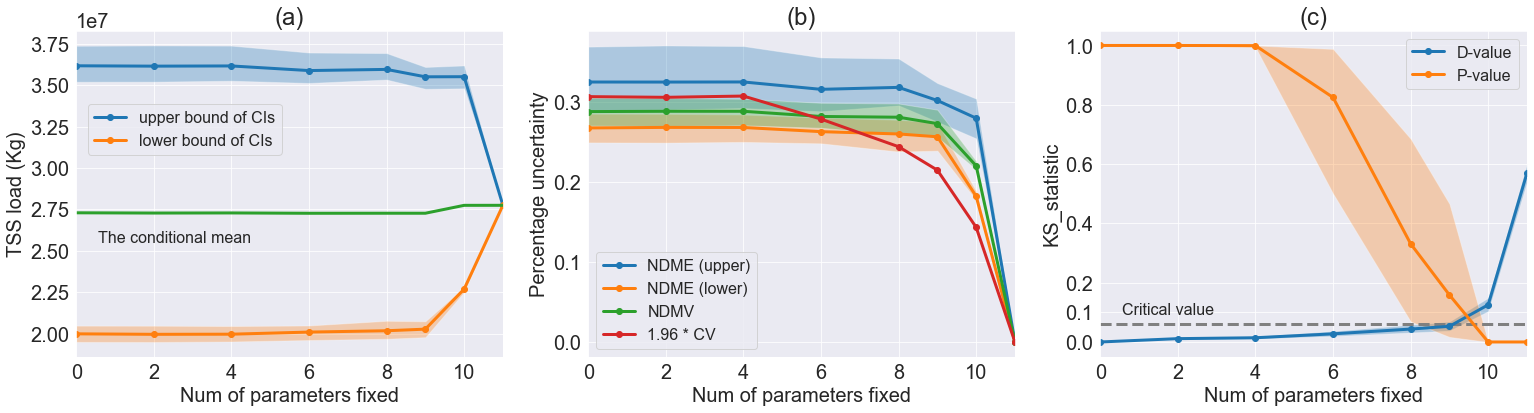

In [53]:
# Line plot
plt.rcParams["text.usetex"] = False
sns.set_style('darkgrid')
fs = 16
fig, axes = plt.subplots(1, 3, sharex=True)
x_col = 'Num of parameters fixed'
ax = df.plot(x=x_col, y=filename[0:2], 
            figsize=(26, 6), marker='o', ax=axes[0])
ax.fill_between(df.loc[:, x_col], df.cf_upper_lower, df.cf_upper_upper, alpha=0.3)
ax.fill_between(df.loc[:, x_col], df.cf_lower_lower, df.cf_lower_upper, alpha=0.3)            
             
ax.plot(df.loc[:, x_col], df.cond_mean)          
ax.text(0.05, 0.35, 'The conditional mean', transform=ax.transAxes, fontsize=fs) #c='k',

ax.set_ylabel('TSS load (Kg)')
ax.legend(['upper bound of CIs', 'lower bound of CIs'], fontsize=fs, bbox_to_anchor=(0.5, 0.8))
ax.set_title("(a)", loc='center', fontsize=24)

ax1 = df.plot(x_col, ['upper_mean', 'lower_mean', 'cf_median_mean', 'cf_cv'], marker='o', ax=axes[1])
ax1.fill_between(df.loc[:, x_col], df.upper_mean_lower, df.upper_mean_upper, alpha=0.3)
ax1.fill_between(df.loc[:, x_col], df.lower_mean_lower, df.lower_mean_upper, alpha=0.3)
ax1.fill_between(df.loc[:, x_col], df.cf_median_lower, df.cf_median_upper, alpha=0.3)
ax1.set_ylabel('Percentage uncertainty') 
ax1.legend(['NDME (upper)', 'NDME (lower)', 'NDMV', '1.96 * CV'], fontsize=fs)
ax1.set_title("(b)", loc='center', fontsize=24);

ax2 = df.plot(x_col,['ks', 'pvalue'], marker='o', ax=axes[2])
ax2.fill_between(df.loc[:, x_col], df.ks_lower, df.ks_upper, alpha=0.3)
ax2.fill_between(df.loc[:, x_col], df.pvalue_lower, df.pvalue_upper, alpha=0.3)
ax2.hlines(0.061, xmin=0, xmax=11, linestyle = '--', color='grey')          
ax2.text(0.05, 0.13, 'Critical value', transform=ax2.transAxes, fontsize=fs) #c='k',
ax2.set_xlim(*x_range)
ax2.set_yticks([0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0])
ax2.set_ylabel('KS_statistic')
ax2.legend(['D-value', 'P-value'], fontsize=fs) ;
ax2.set_xlabel(x_col);
ax2.set_title("(c)", loc='center', fontsize=24);
fpath_save = '../output/paper0915/figure/'
plt.savefig(f'{fpath_save}/figure7_uncertainty_communication.png', format='png', dpi=300, bbox_inches='tight')

## Figure 8 Line plot for showing robustness of error estimation

In [3]:
# Adaptive evaluation of error measure
filepath = '../output/paper0915/error_measures/1029_cal/'
filename = ['cf_lower_adaptive', 'cf_lower_lower_adaptive', 'cf_lower_upper_adaptive',
            'cf_upper_adaptive', 'cf_upper_lower_adaptive', 'cf_upper_upper_adaptive', 'cond_mean_adaptive']# 'stats_uncond_adaptive'

In [4]:
# sort the dataframe for plot
df = pd.DataFrame()
for fn in filename[:]:
    print(fn)
    df[fn] = pd.read_csv(f'{filepath}{fn}.csv', index_col = 'Unnamed: 0').iloc[2]
# df.loc[:, 'median'] = (df.loc[:, filename[0]] + df.loc[:, filename[3]]) / 2 # only use the mean of CIs for calculation
cols = df.columns

cf_lower_adaptive
cf_lower_lower_adaptive
cf_lower_upper_adaptive
cf_upper_adaptive
cf_upper_lower_adaptive
cf_upper_upper_adaptive
cond_mean_adaptive


In [5]:
df_ratio = pd.DataFrame(index=df.index, columns=df.columns)
for fn in filename[:-1]:
    if 'cf_lower' in fn:
        df_ratio.loc[:, fn] = (df.loc[:, cols[-1]] - df.loc[:, fn]) / df.loc[:, cols[-1]]
    else:
        df_ratio.loc[:, fn] = (df.loc[:, fn] - df.loc[:, cols[-1]]) / df.loc[:, cols[-1]]
df_ratio.loc[:, cols[-1]] = df.loc[:,cols[-1]]

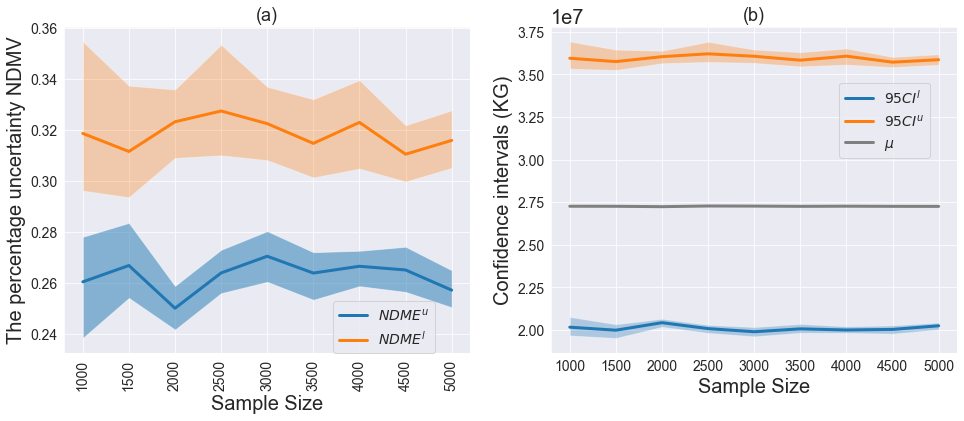

In [8]:

plt.rcParams.update({'font.size': 8})
fs=14
sns.set_style('darkgrid')
fig, axes = plt.subplots(1, 2)
ind = list(df.index)
df = df.loc[ind[0:9], :]
ind = list(df.index)

ax1 = df_ratio.loc[ind, cols[[0, 3]]].plot(ax=axes[0])
plt.sca(axes[1])
plt.xticks(range(len(df.index)), df_ratio.index[0:9], rotation=90)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.fill_between(df.index, df_ratio.loc[ind,cols[1]], df_ratio.loc[ind, cols[2]], alpha=0.5)
ax1.fill_between(df.index, df_ratio.loc[ind, cols[4]], df_ratio.loc[ind, cols[5]], alpha=0.3)
ax1.set_xlabel('Sample Size');
ax1.set_ylabel('The percentage uncertainty NDME');
ax1.legend([f'$NDME^l$', f'$NDME^u$'], bbox_to_anchor=[0.93, 0.18], fontsize=fs);
ax1.set_title('(a)', loc='center', fontsize=18)

ax = df[cols[[0, 3]]].plot(figsize=(16, 6), ax=axes[1])
plt.sca(axes[0])
df[cols[-1]].plot(ax=ax, color='grey')
plt.xticks(range(len(df.index)), df.index, rotation=90)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.fill_between(df.index, df[cols[1]], df[cols[2]], alpha=0.3)
ax.fill_between(df.index, df[cols[4]], df[cols[5]], alpha=0.3)
ax.set_xlabel('Sample Size');
ax.set_ylabel('Confidence intervals (KG)');
ax.legend([f'$95CI^l$', f'$95CI^u$', r'$\mu$'], bbox_to_anchor=[0.95, 0.85], fontsize=fs)
ax.set_title('(b)', loc='center', fontsize=18);
plt.savefig('../output/paper0915/figure/'+'conf_adaptive_two_panels_5000.png', format='png', dpi=300, layout='tight')

## Compare results from different factor fixing practice

In [2]:
# prepare the data for plot: confidence intervals and the coefficient of variation
filepath = '../output/paper0915/error_measures/1029_cal/'
filename = ['cf_upper', 'cf_lower', 'cv', 'ks', 'pvalue', 'cf_upper_upper', 
'cf_upper_lower', 'cf_lower_upper', 'cf_lower_lower',
'ks_lower', 'ks_upper', 'pvalue_lower', 'pvalue_upper', 'cond_mean']

# get data in the corresponding column
num_params = 11
col_filter = ['nsample_156']
df = pd.DataFrame(index=np.arange(num_params), columns=filename)
x_range = [0, num_params]
for f in filename:
    df[f] = pd.read_csv(f'{filepath}{f}.csv').loc[:, col_filter]
df.index = np.arange(df.shape[0], 0, -1)
df.index.name = 'Num of parameters fixed'
df.reset_index(inplace=True)
# add the one with no parameter fixed

In [3]:
filepath = '../output/paper0915/'
files = ['fix_dummy.csv', 'fix_threshold.csv']
df_plot = pd.read_csv(filepath+files[0], index_col = 'Unnamed: 0').T
df_plot.rename(columns = {0: 'dummy'}, inplace=True)
df_plot.loc[:, 'threshold'] = pd.read_csv(filepath+files[1], index_col = 'Unnamed: 0').T


In [4]:
for ii in list(df_plot.index):
    if ii in df.columns:
        df_plot.loc[ii, 'framework'] = df.loc[2, ii]
    else:
        df_plot.loc[ii, 'framework'] = np.nan
df_plot.dropna(axis=0, inplace=True)
df = df_plot.T

In [5]:
# add the relative change of CIs formed as the deviation to median
cf_median = (df.loc[:, 'cf_upper'] + df.loc[:, 'cf_lower']) / 2
df.loc[:, 'upper_mean'] = (df.cf_upper - df.cond_mean) / df.cond_mean
df.loc[:, 'upper_mean_lower'] = (df.cf_upper_lower - df.cond_mean) / df.cond_mean
df.loc[:, 'upper_mean_upper'] = (df.cf_upper_upper - df.cond_mean) / df.cond_mean
df.loc[:, 'lower_mean'] = (df.cond_mean - df.cf_lower) / df.cond_mean
df.loc[:, 'lower_mean_lower'] = (df.cond_mean - df.cf_lower_lower) / df.cond_mean
df.loc[:, 'lower_mean_upper'] = (df.cond_mean - df.cf_lower_upper) / df.cond_mean
df.loc[:, 'cf_median_mean'] = (cf_median - df.cf_lower) / cf_median
df.loc[:, 'cf_median_lower'] = (cf_median - df.cf_lower_lower) / cf_median
df.loc[:, 'cf_median_upper'] = (cf_median - df.cf_lower_upper) / cf_median
df.loc[:, 'cf_cv'] = 1.96 * df['cv']

In [6]:
df.reset_index(inplace=True)

In [7]:
df

,index,cf_upper,cf_lower,ks,pvalue,cv,cf_upper_upper,cf_upper_lower,cf_lower_upper,cf_lower_lower,...,upper_mean,upper_mean_lower,upper_mean_upper,lower_mean,lower_mean_lower,lower_mean_upper,cf_median_mean,cf_median_lower,cf_median_upper,cf_cv
0,dummy,3.664791e+07,1.980886e+07,0.015576,0.997881,0.159789,3.715867e+07,3.625529e+07,2.038074e+07,1.944191e+07,...,0.332212,0.317939,0.350779,0.279916,0.293255,0.259127,0.298265,0.311264,0.278005,0.313187
1,threshold,3.667874e+07,1.982089e+07,0.021801,0.954683,0.164281,3.730234e+07,3.596055e+07,2.029951e+07,1.952569e+07,...,0.332981,0.306881,0.355644,0.279668,0.290396,0.262274,0.298371,0.308821,0.281428,0.321990
2,framework,3.550482e+07,2.026505e+07,0.052779,0.158581,0.109705,3.609822e+07,3.478045e+07,2.073815e+07,1.977936e+07,...,0.302194,0.275626,0.323958,0.256748,0.274561,0.239397,0.273262,0.290679,0.256296,0.215023


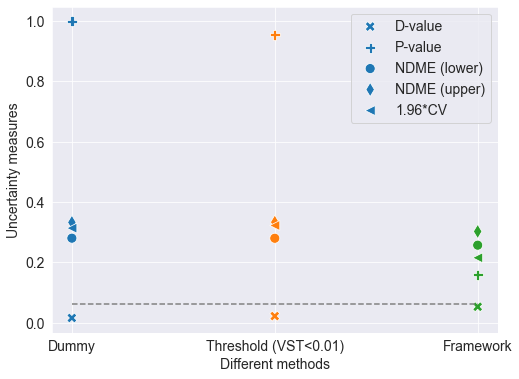

In [35]:
fig, ax = plt.subplots(figsize=[8,6])
sns.set_style('darkgrid')
markers = ['X','P', 'o', 'd', '<']
metrics = ['ks', 'pvalue', 'lower_mean', 'upper_mean', 'cf_cv']
ldg = ['D-value', 'P-value', 'NDME (lower)', 'NDME (upper)', '1.96*CV']
for i in range(len(metrics)):
    col = metrics[i]
    sns.scatterplot(ax=ax, x="index", y=col, hue="index", data=df, s = 100, marker=markers[i], legend=False);
ax.hlines(0.061, xmin=ax.get_xticks()[0], xmax=ax.get_xticks()[-1], linestyle = '--', color='grey')          
plt.legend(markers, loc='upper right', labels=ldg, fontsize=14)
ax.set_xticklabels(['Dummy', 'Threshold (VST<0.01)', 'Framework'], size=14)
ax.set_yticklabels(np.round(ax.get_yticks(), 2), size=14)
ax.set_xlabel('Different methods', size=14)
ax.set_ylabel('Uncertainty measures', size=14);
plt.savefig('../output/paper0915/figure/Figure_comp_practices.png', format='png', dpi=300)


In [16]:
list(ax.get_yticklabels())[0]

Text(0, -0.2, '')